
# K-Means Clustering con Datos de una API Pública (USGS Earthquakes)

Este notebook descarga datos de terremotos desde la API pública de **USGS** (últimos 30 días), 
realiza **preprocesamiento**, selecciona **K** por métrica (**silhouette** e inspección de codo / *inertia*), 
entrena un modelo **K-Means**, evalúa métricas de *clustering* (**silhouette**, **Calinski–Harabasz**, **Davies–Bouldin**) 
y genera visualizaciones con **matplotlib**.

> Nota: Para ejecutar las celdas de descarga de datos necesitas conexión a Internet.


In [1]:

# --- Imports ---
import json
import math
import time
from datetime import datetime
import requests  # Necesita Internet para ejecutar la celda de descarga
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


In [2]:

# --- Configuración y helpers ---
USGS_URL = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"

def fetch_usgs_earthquakes(url: str = USGS_URL) -> pd.DataFrame:
    """Descarga el GeoJSON de USGS y lo transforma a DataFrame.

    Devuelve columnas: [time_utc, place, mag, lon, lat, depth_km].
    """
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    data = resp.json()

    rows = []
    for f in data.get("features", []):
        props = f.get("properties", {}) or {}
        geom  = f.get("geometry", {}) or {}
        coords = geom.get("coordinates", [None, None, None]) or [None, None, None]
        lon, lat, depth = None, None, None
        if isinstance(coords, (list, tuple)) and len(coords) >= 3:
            lon, lat, depth = coords[:3]
        # Convert ms to datetime
        t = props.get("time")
        t_utc = None
        if t is not None:
            t_utc = datetime.utcfromtimestamp(t/1000.0)

        rows.append({
            "time_utc": t_utc,
            "place": props.get("place"),
            "mag": props.get("mag"),
            "lon": lon,
            "lat": lat,
            "depth_km": depth
        })
    df = pd.DataFrame(rows)
    return df

def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Limpieza básica: elimina nulos en features clave y filtra magnitudes o coordenadas inválidas."""
    dfc = df.copy()
    dfc = dfc.dropna(subset=["mag", "lon", "lat", "depth_km"]).reset_index(drop=True)
    # Filtros simples razonables
    dfc = dfc[(dfc["mag"] >= -1) & (dfc["mag"] <= 10)]
    dfc = dfc[(dfc["lon"] >= -180) & (dfc["lon"] <= 180)]
    dfc = dfc[(dfc["lat"] >= -90) & (dfc["lat"] <= 90)]
    return dfc

def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """Crea matriz de características numéricas para K-Means."""
    # Usamos magnitud, profundidad y coordenadas. Se podría añadir engineered features.
    feats = df[["mag", "depth_km", "lon", "lat"]].copy()
    return feats


In [3]:

# --- Descarga de datos desde la API pública ---
df_raw = fetch_usgs_earthquakes()
print("Filas descargadas:", len(df_raw))
df_raw.head()


C:\Users\User\AppData\Local\Temp\ipykernel_3652\1134722775.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  t_utc = datetime.utcfromtimestamp(t/1000.0)


Filas descargadas: 8322


,time_utc,place,mag,lon,lat,depth_km
0,2025-10-24 12:20:22.695,"66 km WNW of Tyonek, Alaska",0.60,-152.287700,61.289400,7.4000
1,2025-10-24 12:16:56.100,"5 km WNW of The Geysers, CA",1.05,-122.810997,38.792332,2.8700
2,2025-10-24 11:43:49.730,"6 km WNW of The Geysers, CA",1.32,-122.817665,38.798832,-0.6500
3,2025-10-24 11:33:50.430,"23 km ESE of Little Lake, CA",1.64,-117.669500,35.870500,5.0600
4,2025-10-24 11:24:35.250,"14 km SSW of Big Spring, Texas",1.20,-101.547000,32.132000,8.4229


In [4]:

# --- Limpieza y construcción de features ---
df = basic_clean(df_raw)
X = build_features(df)

print("Filas tras limpieza:", len(df))
X.describe()


Filas tras limpieza: 8206


,mag,depth_km,lon,lat
count,8206.000000,8206.000000,8206.000000,8206.000000
mean,1.595456,19.956276,-104.206129,39.453929
std,1.285172,50.682117,70.878326,17.354323
min,-1.000000,-3.180000,-179.972300,-60.359400
25%,0.832500,3.500000,-145.455325,33.179000
50%,1.370000,7.400000,-117.783750,38.759001
75%,1.920000,12.880000,-103.345000,51.695525
max,7.600000,643.060000,179.935500,85.064300


In [5]:

# --- Estandarización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Shape de X_scaled:", X_scaled.shape)


Shape de X_scaled: (8206, 4)


Mejor k por silhouette: 2


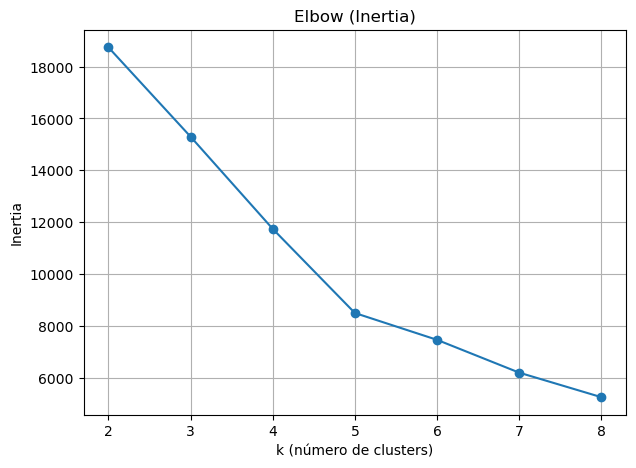

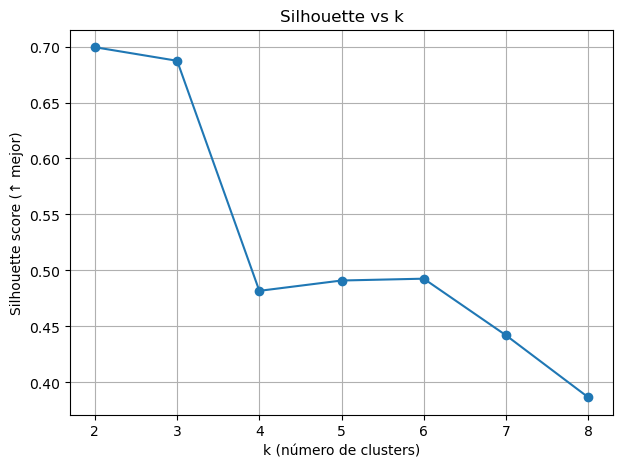

In [6]:

# --- Selección de K ---
k_values = list(range(2, 9))  # 2..8
inertias = []
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan
    sil_scores.append(sil)

best_k = k_values[int(np.nanargmax(sil_scores))]
print("Mejor k por silhouette:", best_k)

# --- Gráfico de Codo (Inertia) ---
plt.figure(figsize=(7, 5))
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow (Inertia)")
plt.xlabel("k (número de clusters)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# --- Gráfico de Silhouette ---
plt.figure(figsize=(7, 5))
plt.plot(k_values, sil_scores, marker="o")
plt.title("Silhouette vs k")
plt.xlabel("k (número de clusters)")
plt.ylabel("Silhouette score (↑ mejor)")
plt.grid(True)
plt.show()


In [7]:

# --- Entrenamiento final con best_k ---
km_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels = km_final.fit_predict(X_scaled)

df_clusters = df.copy()
df_clusters["cluster"] = labels
df_clusters["cluster"] = df_clusters["cluster"].astype(int)

print("Conteo por clúster:")
print(df_clusters["cluster"].value_counts().sort_index())
df_clusters.head()


Conteo por clúster:
cluster
0    7389
1     817
Name: count, dtype: int64


,time_utc,place,mag,lon,lat,depth_km,cluster
0,2025-10-24 12:20:22.695,"66 km WNW of Tyonek, Alaska",0.60,-152.287700,61.289400,7.4000,0
1,2025-10-24 12:16:56.100,"5 km WNW of The Geysers, CA",1.05,-122.810997,38.792332,2.8700,0
2,2025-10-24 11:43:49.730,"6 km WNW of The Geysers, CA",1.32,-122.817665,38.798832,-0.6500,0
3,2025-10-24 11:33:50.430,"23 km ESE of Little Lake, CA",1.64,-117.669500,35.870500,5.0600,0
4,2025-10-24 11:24:35.250,"14 km SSW of Big Spring, Texas",1.20,-101.547000,32.132000,8.4229,0


In [8]:

# --- Métricas de Clustering ---
sil = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan
ch = calinski_harabasz_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan
db = davies_bouldin_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan

print(f"Silhouette Score: {sil:.4f}")
print(f"Calinski–Harabasz: {ch:.2f}")
print(f"Davies–Bouldin: {db:.4f} (↓ mejor)")


Silhouette Score: 0.6994
Calinski–Harabasz: 6162.26
Davies–Bouldin: 0.8748 (↓ mejor)


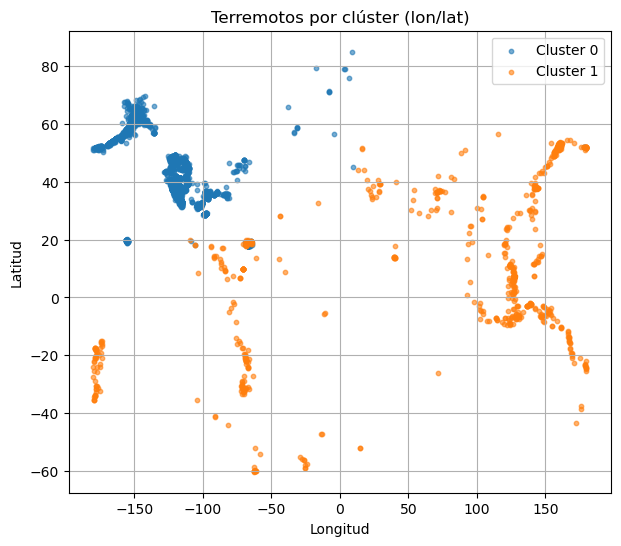

In [9]:

# --- Visualización: Longitud vs Latitud coloreado por clúster ---
plt.figure(figsize=(7, 6))
for c in sorted(df_clusters["cluster"].unique()):
    sub = df_clusters[df_clusters["cluster"] == c]
    plt.scatter(sub["lon"], sub["lat"], s=10, label=f"Cluster {c}", alpha=0.6)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Terremotos por clúster (lon/lat)")
plt.legend()
plt.grid(True)
plt.show()


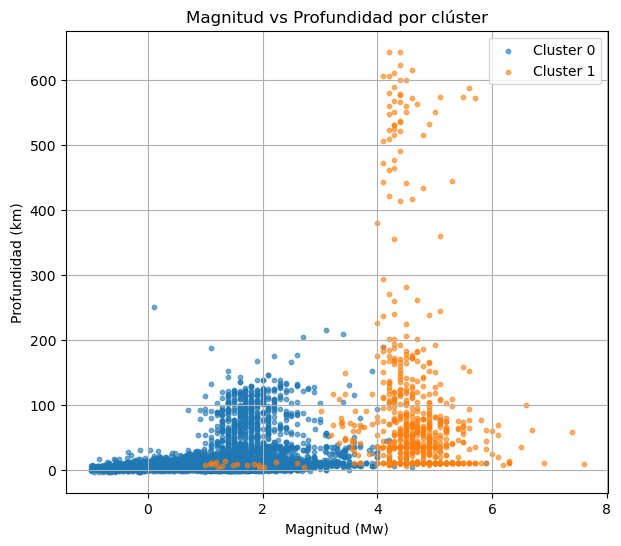

In [10]:

# --- Visualización: Magnitud vs Profundidad ---
plt.figure(figsize=(7, 6))
for c in sorted(df_clusters["cluster"].unique()):
    sub = df_clusters[df_clusters["cluster"] == c]
    plt.scatter(sub["mag"], sub["depth_km"], s=10, label=f"Cluster {c}", alpha=0.6)
plt.xlabel("Magnitud (Mw)")
plt.ylabel("Profundidad (km)")
plt.title("Magnitud vs Profundidad por clúster")
plt.legend()
plt.grid(True)
plt.show()


In [12]:

# --- Info de entorno ---
import sys
print(sys.version)
print("Ejecutado:", datetime.now().isoformat())


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Ejecutado: 2025-10-24T08:06:10.267128
